In [1]:
import numpy as np
import math
from random import *

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
from qiskit import Aer, QuantumRegister, execute
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
from qiskit.extensions.standard import *
from qiskit.tools.visualization import circuit_drawer
from qiskit.aqua.operators import WeightedPauliOperator
from scipy.optimize import minimize
np.set_printoptions(precision=3, suppress=True)

<div style="font-size: 25px">
Method 1: To get both $ \frac{1}{\sqrt{2}} \left(\left| 00 \right\rangle + \left| 11 \right\rangle \right) $ and  $ \frac{1}{\sqrt{2}} \left(\left| 00 \right\rangle - \left| 11 \right\rangle \right) $
</div>

The procedure starts with two qubits in the $ \left| 00 \right\rangle $ state. The first qubit is rotated about the y-axis in the block sphere using the RY gate. The RY rotation matrix is given by $ \begin{bmatrix} \cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2}) \\ \sin(\frac{\theta}{2}) & \cos(\frac{\theta}{2}) \end{bmatrix} $. After rotation, state of the first qubit is given by $ \begin{bmatrix} \cos(\frac{\theta}{2}) \\ \sin(\frac{\theta}{2}) \end{bmatrix} $. The second qubit is then passed through a CNOT gate with the first qubit as the control qubit, giving a combined state of:

\begin{equation}
\left| \psi \right\rangle = \begin{bmatrix}
\cos(\frac{\theta}{2})
\\ 0
\\ 0
\\ \sin(\frac{\theta}{2})
\end{bmatrix}
\end{equation}

From the above state, one can see that the ratio of probabilities of getting $ \left| 11 \right\rangle $ and $\left| 00 \right\rangle$ from the two qubits after measurement is given by $\tan^{2}(\frac{\theta}{2})$. To satisfy the requirement of the problem, the qubits must be in a state where the probabilities of getting $ \left| 11 \right\rangle $ and $\left| 00 \right\rangle$ are equal.

Hence, a cost function $C(\theta) = {(\tan^{2}(\frac{\theta}{2})-1)}^{2}$ is constructedand the parameter, $\theta$, is variationally changed until $C(\theta)$ is minimised (or within a certain tolerance level). This is done using a simple gradient descent.

<img src="files/Method 1.png">

(Graph obtained from https://www.desmos.com/calculator)

The above image shows the regions of solutions for $\theta$ for a tolerance value of $0.01$.

It must be noted here that to cover the entire Bloch sphere, an ansatz of RX and RY gates is required. In this solution, the RX gate has been ignored to avoid the use of two parameters and additional complexity. Had the RX gate been present, one would get additional solutions where the $\left| 1 \right\rangle$ state of the first qubit would have an imaginary phase. It can easily be seen that each point on the unit circle on the XY plane is a solution for the first qubit. The solutions obtained using just the RY gate is a subset of the actual solution set. 

Further, the solutions are restricted to the zones nearest to the origin, in the above image, as the $\theta$ in the other zones are $\theta_{solution} + 2n\pi$.

In [2]:
backend = BasicAer.get_backend('qasm_simulator')
theta = np.random.uniform(0.0,2*np.pi)
print("Starting Parameter:",theta)
print()
a = 0.01
while(True):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)
    circuit.ry(theta,q[0])
    circuit.cx(q[0], q[1])
    circuit.measure(q, c)
    job = execute(circuit, backend, shots=1000)
    probdict = job.result().get_counts(circuit)
    try:
        count00 = probdict['00']
    except:
        theta += 2*randint(0,1) - 1 
        #nudging the state vector a little from along the Z axis on either side with equal probability
        continue
    try:
        count11 = probdict['11']
    except:
        theta += 2*randint(0,1) - 1
        #nudging the state vector a little from along the Z axis on either side with equal probability
        continue
    
    prob = count11/count00
    
    prob1 = math.tan(theta/2)*math.tan(theta/2)
    cost = (prob1-1)*(prob1-1)

    if cost <= 0.0001:
        print("Optimal Parameter:",theta)
        break
    dcost = 2*(math.tan(theta/2)*math.tan(theta/2)-1)*math.tan(theta/2)/math.cos(theta/2)/math.cos(theta/2)
    theta = (theta - a*dcost)%(2*np.pi)

Starting Parameter: 5.060044378332174

Optimal Parameter: 4.717185087408674


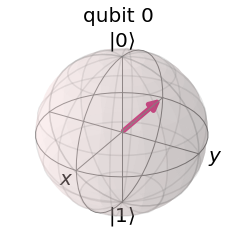

In [3]:
q1 = QuantumRegister(1)
c1 = ClassicalRegister(1)
cir = QuantumCircuit(q1,c1)
cir.ry(theta,q1[0])
job1 = execute(cir, backend=BasicAer.get_backend('statevector_simulator'))
plot_bloch_multivector(job1.result().get_statevector(cir))

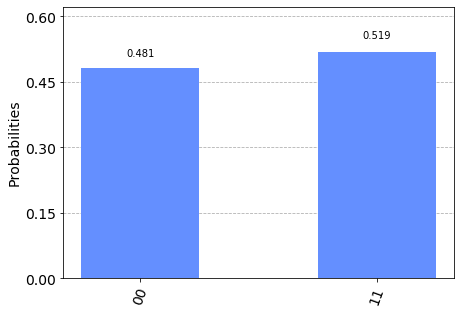

In [4]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.ry(theta,q[0])
circuit.cx(q[0], q[1])
circuit.measure(q, c)
job = execute(circuit, backend, shots=1000)
plot_histogram(job.result().get_counts(circuit))

<div style="font-size: 25px">
    Method 2: To get only $ \frac{1}{\sqrt{2}} (\left| 00 \right\rangle + \left| 11 \right\rangle) $ 
</div>

Extending the approach in Method 1, it can be observed that changing the cost function to $ C(\theta) = {(\tan(\frac{\theta}{2})-1)}^{2} $ gets rid of some of the solution zones, as shown in the image below.

<img src="files/Method 2.png">

(Graph obtained from https://www.desmos.com/calculator)

The solution zones that got eliminated, were responsible for obtaining the state $ \frac{1}{\sqrt{2}} (\left| 00 \right\rangle - \left| 11 \right\rangle) $ (along negative-x axis on the Bloch sphere). Removing these solutions ensures that the state $ \frac{1}{\sqrt{2}} (\left| 00 \right\rangle + \left| 11 \right\rangle) $ is obtained.

Starting Parameter: 0.8746120022438574

Optimal Parameter: 1.5609355544749932


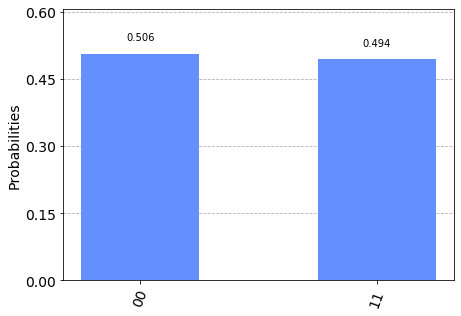

In [5]:
backend = BasicAer.get_backend('qasm_simulator')
theta = np.random.uniform(0.0,2*np.pi)
print("Starting Parameter:",theta)
print()
a = 0.01
while(True):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)
    circuit.ry(theta,q[0])
    circuit.cx(q[0], q[1])
    circuit.measure(q, c)
    job = execute(circuit, backend, shots=1000)
    probdict = job.result().get_counts(circuit)
    try:
        count00 = probdict['00']
    except:
        theta += 2*randint(0,1) - 1
        #nudging the state vector a little from along the Z axis on either side with equal probability
        continue
    try:
        count11 = probdict['11']
    except:
        theta += 2*randint(0,1) - 1
        #nudging the state vector a little from along the Z axis on either side with equal probability
        continue
    
    prob = count11/count00
    #print(prob)
    #cost = (prob1-1)*(prob1-1)
    #print(count00, count11, prob, cost)
    
    prob1 = math.tan(theta/2)
    cost = (prob1-1)*(prob1-1)
    #print(theta, cost)
    if cost <= 0.0001:
        print("Optimal Parameter:",theta)
        break
    dcost = (math.tan(theta/2)-1)/math.cos(theta/2)/math.cos(theta/2)
    theta = (theta - a*dcost)%(2*np.pi)
#print(theta)

q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.ry(theta,q[0])
circuit.cx(q[0], q[1])
circuit.measure(q, c)
job = execute(circuit, backend, shots=1000)
plot_histogram(job.result().get_counts(circuit))

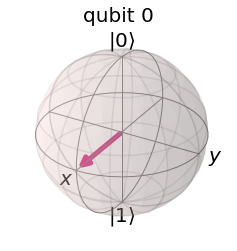

In [6]:
q1 = QuantumRegister(1)
c1 = ClassicalRegister(1)
cir = QuantumCircuit(q1,c1)
cir.ry(theta,q1[0])
job1 = execute(cir, backend=BasicAer.get_backend('statevector_simulator'))
plot_bloch_multivector(job1.result().get_statevector(cir))

<div style="font-size: 25px">
    Method 3: To get only $ \frac{1}{\sqrt{2}} (\left| 00 \right\rangle + \left| 11 \right\rangle) $ using VQE
</div>

The basis for this method is the observation that the Pauli-*X* matrix has eigenvalues 1 and -1, with eigenvectors $ \frac{1}{\sqrt{2}} (\left| 0 \right\rangle + \left| 1 \right\rangle) $ and $ \frac{1}{\sqrt{2}} (- \left| 0\right\rangle + \left| 1 \right\rangle) $, respectively. Thus, one could use VQE with -X as the target Hamiltonian to get its ground state and corresponding energy.

Two qubits are initialised to the $ \left| 00 \right\rangle $ state. Using VQE and RY as the ansatz on the first qubit, it is transformed to the ground state of -*X*, given by $ \frac{1}{\sqrt{2}} (\left| 0 \right\rangle + \left| 1 \right\rangle) $. The first and second qubits then act as the control and target qubits for a CNOT gate to get the required $ \frac{1}{\sqrt{2}} (\left| 0 \right\rangle + \left| 1 \right\rangle) $.

If *X* was used as the target Hamiltonian, one would still end up with an equal superposition of $ \left| 00 \right\rangle $ and $ \left| 11 \right\rangle $, i.e., $ \frac{1}{\sqrt{2}} (- \left| 00 \right\rangle + \left| 11 \right\rangle) $. Similarly, the Pauli-*Y* matrix can be used to obtain $ \frac{1}{\sqrt{2}} (i\left| 00 \right\rangle + \left| 11 \right\rangle) $ and $ \frac{1}{\sqrt{2}} (\left| 00 \right\rangle + i\left| 11 \right\rangle) $

In [7]:
'''Creating the target Hamiltonian Matrix: -X'''
pauli_dict = {
        'paulis': [
                   {"coeff": {"imag": 0.0, "real": -1}, "label": "X"},
                   ]
    }
H = WeightedPauliOperator.from_dict(pauli_dict)

In [8]:
def quantum_circuit(param, pauli):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)
   
    circuit.ry(param, q[0])
    
    if pauli == 'X':
        circuit.u2(0, np.pi, q[0])
        circuit.measure(q[0], c[0])
    else:
        raise ValueError('Not valid input for measurement: input should be "X"')
        
    shots = 1000
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots = shots)
    result = job.result()
    counts = result.get_counts()
    #print(counts)
    try:
        count0 = counts['0']
    except:
        count0 = 0
    try:
        count1 = counts['1']
    except:
        count1 = 0
    expectation_value = (count0 - count1) / shots
    return expectation_value

In [9]:
def VQE(param):
    exp_XX = -1 * quantum_circuit(param, 'X')
    
    exp = exp_XX
    return exp

In [10]:
parameter = np.random.uniform(0.0, 2*np.pi)
tolerance = 0.001 
print('Starting Parameter Value', parameter)
vqe = minimize(VQE, parameter, method = "COBYLA", tol = tolerance)
print('Final Parameter Value', vqe.x)
print('Ground State Energy of Target Hamiltonian:', vqe.fun)

Starting Parameter Value 1.0273323306127076
Final Parameter Value 1.5898323306127073
Ground State Energy of Target Hamiltonian: -1.0


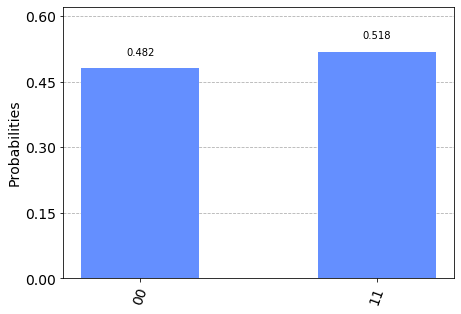

In [11]:
q1 = QuantumRegister(2)
c1 = ClassicalRegister(2)
cir = QuantumCircuit(q1, c1)   
cir.ry(vqe.x, q1[0])
cir.cx(q1[0], q1[1])
cir.measure(q1, c1)
job1 = execute(cir, backend = BasicAer.get_backend('qasm_simulator'), shots = 1000)
counts = job1.result().get_counts(cir)
plot_histogram(counts)